# Time Series with LSTM using Keras on CPUs

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import warnings
from keras import regularizers
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout,LSTM 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
% matplotlib inline

Using TensorFlow backend.


# Taking a look of a sample of the data

In [2]:
# load the dataset
plt.figure(figsize = (20,10))
dataframe = pandas.read_csv('timeSeriesDataForInterview_Train.csv')
dataset = dataframe.values
dataset = dataset.astype('float32')

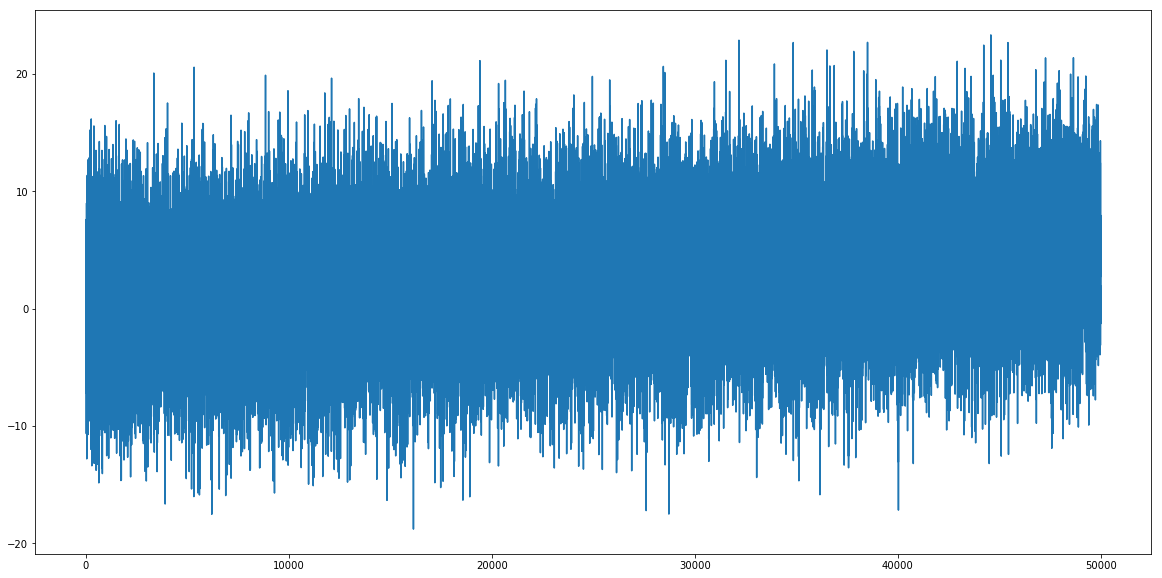

In [96]:
plt.figure(figsize = (20,10))
plt.plot(dataset)
plt.show()

- only used a sample of the data for the rest of the analysis since running the entire dataset would be computationally too intensive on my laptop
- also based on the plot, it seems like there is not clear pattern throughout the entire dataset, so taking a small portion of it should suffice my analysis

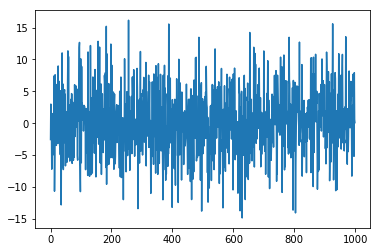

In [106]:
plt.plot(dataset[:1000])
plt.show()

# Note:

- based on the plot, the data does not seem to have a trend, be seasonal, or cyclical.  There are fluctuations but there does not appear to be any patterns that would help with developing a forecasting model.  

- This is referred to referred to as "White Noise", where variables are independent and identically distributed with a mean of zero, where you cannot reasonably create a model with it without some kind of transformation.  

In [107]:
dataframe.describe()

,5.48086328436442
count,49999.000000
mean,2.551419
std,5.257453
min,-18.797140
25%,-1.029974
50%,2.553947
75%,6.082514
max,23.319396


- mean is close to zero

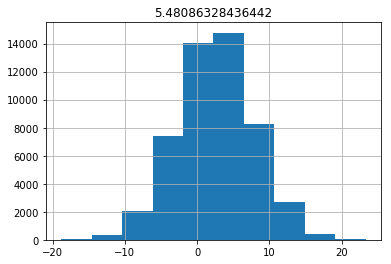

In [108]:
dataframe.hist();

- data appears normal, which means the data appears to be guassian white noise

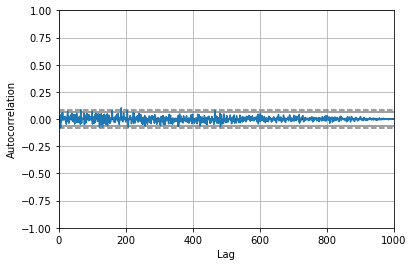

In [109]:
# autocorrelation
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(dataset[:1000])
plt.show()

- there are some sporadic spikes, but the data doesn't seem to show any obvious autocorrelation pattern.

# So how do we predict on data that is not stationary? 

There are ways to make series stationary or find trends, despite varying mean over time and fluctuations in the data.

# Proposed Solution:

- Log Transformation to penalize higher values
- taking rolling averages or moving average and predict on that

In [3]:
log=numpy.log(dataset[:1000])

# But logging the data produces NAN values...

In [111]:
log[:20]

array([[        nan],
       [ 1.09772146],
       [-0.49036855],
       [        nan],
       [        nan],
       [ 0.41534722],
       [-0.38858545],
       [        nan],
       [-0.8886171 ],
       [        nan],
       [        nan],
       [ 0.33387759],
       [ 2.00622177],
       [        nan],
       [        nan],
       [ 2.02810025],
       [ 0.5572018 ],
       [ 0.56487828],
       [ 0.67913687],
       [        nan]], dtype=float32)

# Instead of dropping NA , I decided to interpolate these values:

In [112]:
nans, x= numpy.isnan(log), lambda z: z.nonzero()[0]  # tracks the Nan and non zero values
log[nans]= numpy.interp(x(nans), x(~nans), log[~nans]) # interpolating values and replacing them

In [113]:
moving_avg = pandas.ewma(log, halflife=12) # exponentially weighted moving average w/ decay factor

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


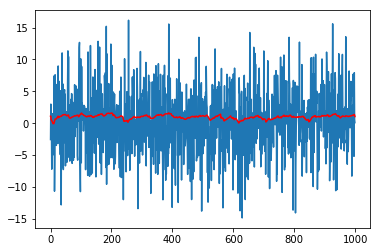

In [115]:
#nans, x= numpy.isnan(moving_avg), lambda z: z.nonzero()[0] 
# interpolating again in case or more Nan
moving_avg[nans]= numpy.interp(x(nans), x(~nans), moving_avg[~nans])
plt.plot(dataset[:1000])
plt.plot(moving_avg, color='red')

- moving average smoothes out the data compared to the original 

In [116]:
# moving average difference to see if the graph is adjusted
ts_log_moving_avg_diff = log - moving_avg

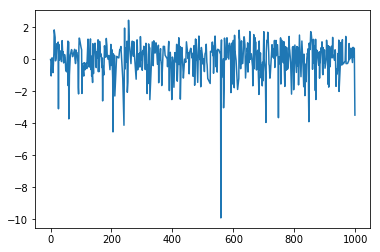

In [117]:
plt.plot(ts_log_moving_avg_diff)

- because of the nature of the graph, I decided to predict on the moving average, because despite taking the moving average difference, the data still looked very volatile. 

- if I had to productionalize the data, this log transformation step would have to be part of the pipeline

# Much of the code below is based on the blog from machinelearningmastery.com time-series prediction with lstm on keras  linked below

In [52]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(moving_avg)

In [53]:
#split into train and test sets
length = len(dataset)
train_size = int(length * 0.67)
test_size = length - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


(670, 330)


In [54]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		dataX.append(dataset[i:(i+look_back), 0])
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [55]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [56]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [66]:
%%time
# create and fit the LSTM network, using a stacked method
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.1)) # preventing overfit
model.add(Activation('sigmoid')) # added a sigmoid function as the activation
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='RMSprop',metrics=['accuracy'])
for i in range(50): #running average of the magnitudes of recent gradients for that weight.
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=True)
    model.reset_states()

Epoch 1/1
10s - loss: 0.0344 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0344 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0342 - acc: 0.0015
Epoch 1/1
9s - loss: 0.0338 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0330 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0313 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0292 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0263 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0243 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0217 - acc: 0.0015
Epoch 1/1
9s - loss: 0.0202 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0290 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0191 - acc: 0.0030
Epoch 1/1
8s - loss: 0.0171 - acc: 0.0030
Epoch 1/1
8s - loss: 0.0180 - acc: 0.0030
Epoch 1/1
8s - loss: 0.0171 - acc: 0.0030
Epoch 1/1
8s - loss: 0.0162 - acc: 0.0030
Epoch 1/1
8s - loss: 0.0169 - acc: 0.0030
Epoch 1/1
8s - loss: 0.0174 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0171 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0157 - acc: 0.0030
Epoch 1/1
8s - loss: 0.0160 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0155 - acc: 0.0015
Epoch 1/1
8s - loss: 0.0162 - acc

# CPU times: user 7min 38s, sys: 6min 7s, total: 13min 46s
# Wall time: 7min 4s

Train Score: 0.13 RMSE
Test Score: 0.07 RMSE


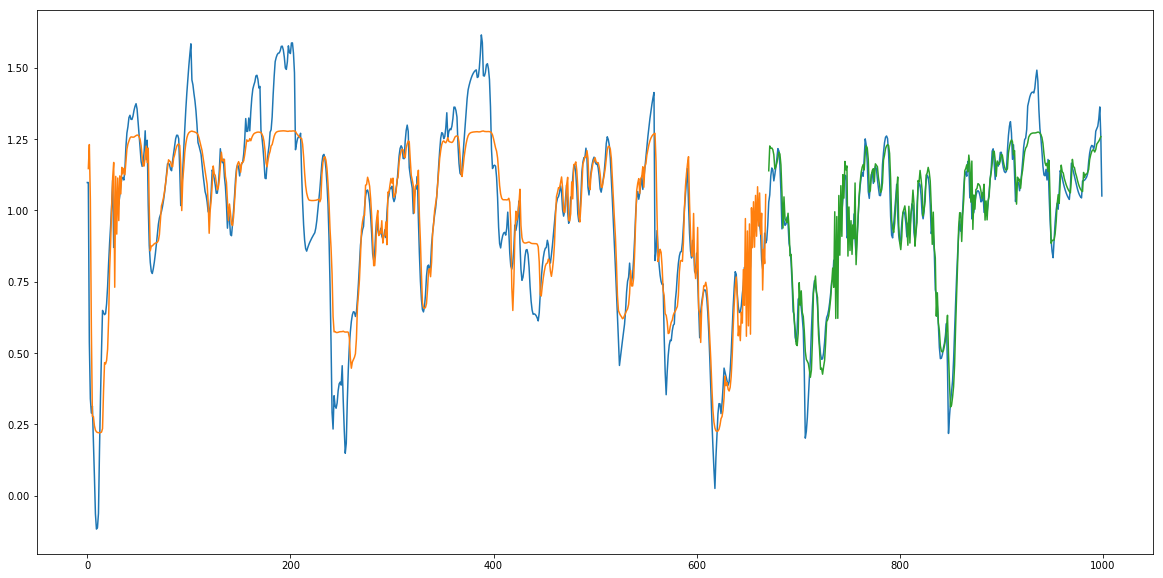

In [67]:
# make predictions
plt.figure(figsize =(20,10))
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

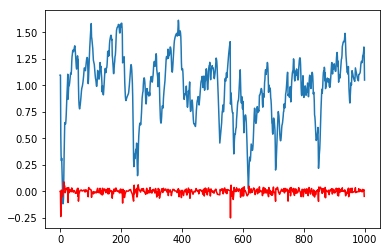

In [72]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(moving_avg, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(moving_avg)
plt.plot(results_MA.fittedvalues, color='red');

Conclusion:

- Using a typical ARIMA model didn't get me the results that I was looking for as shown above
- With Deep Learning and log transformation , I was able to model and predict even though the data was predominantly noisy

# Future Work:

- Create a fully built model with Tensorflow only, not just in the backend

- Use the entire dataset and process it with GPUs in AWS

- Produce a working pipeline to feed new data and have the model produce predictions from it


# Reference:

LSTM with Keras:

http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Time series patterns:

https://www.otexts.org/fpp/6/1

White Noise in Time Series:

http://machinelearningmastery.com/white-noise-time-series-python/

Getting started with Keras:

https://keras.io/getting-started/sequential-model-guide/

How to install Keras and Theano:

http://stackoverflow.com/questions/34097988/how-do-i-install-keras-and-theano-in-anaconda-python-on-windows

Time Series Forecasting Models:

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/